In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as colors
import matplotlib.path as mpath
import scipy.io
import matplotlib.gridspec as gridspec

# functions from gasex module
from gasex.phys import vpress_sw
from gasex.fugacity import fugacity_factor

In [2]:
# make plots look nice
sns.set_context("talk", rc = {"lines.linewidth":2.5})

In [3]:
# helper function
def generateinputs(tests, windproduct):
    parameterizations = ["W14", "L13"]
    #windproducts = ["ncep"]    
    inputs = [[p,w, t] for p in parameterizations for w in windproduct for t in tests]
    print(f"inputs: {inputs}")
    return inputs

# FIGURE 1

In [4]:
# load fronts from Gray et al.
mat = scipy.io.loadmat('datasets/fronts_Gray.mat')
lat_pf=mat['lat_pf'][0] #Polar Front
lon_pf=mat['lon_pf'][0] #Polar Front
lat_siz=mat['lat_siz'][0] #Seasonal Ice Zone
lon_siz=mat['lon_siz'][0] #Seasonal Ice Zone
lat_saf=mat['lat_saf'][0] #Subantarctic Front
lon_saf=mat['lon_saf'][0] #Subantarctic Front
lat_stf=mat['lat_stf'][0] #Subtropical Front
lon_stf=mat['lon_stf'][0] #Subtropical Front

In [5]:
def plotfronts(ax):
    ax.plot(lon_pf[0:1409],lat_pf[0:1409],c="k",lw=2,zorder=4,transform=ccrs.PlateCarree())
    ax.plot(lon_pf[1410:len(lon_pf)],lat_pf[1410:len(lon_pf)],c="k",lw=2,zorder=4,transform=ccrs.PlateCarree())
    ax.plot(lon_siz[0:537],lat_siz[0:537],c="k",lw=2,zorder=4,transform=ccrs.PlateCarree())
    ax.plot(lon_siz[538:len(lon_siz)],lat_siz[538:len(lon_siz)],c="k",lw=2,zorder=4,transform=ccrs.PlateCarree())
    ax.plot(lon_saf[0:2016],lat_saf[0:2016],c="k",lw=2,zorder=4,transform=ccrs.PlateCarree())
    ax.plot(lon_saf[2017:2911],lat_saf[2017:2911],c="k",lw=2,zorder=4,transform=ccrs.PlateCarree())
    ax.plot(lon_stf[0:1871],lat_stf[0:1871],c="k",lw=2,zorder=4,transform=ccrs.PlateCarree())
    ax.plot(lon_stf[1872:len(lon_stf)],lat_stf[1872:len(lon_stf)],c="k",lw=2,zorder=4,transform=ccrs.PlateCarree())

def setupmap(ax):
    ax.set_extent([-180, 180, -90, -30], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND,facecolor='gray',zorder=4)
    #g = ax.gridlines(linestyle='--',zorder=5, draw_labels=False)
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    import matplotlib.path as mpath
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.add_feature(cfeature.OCEAN, facecolor='lightskyblue')

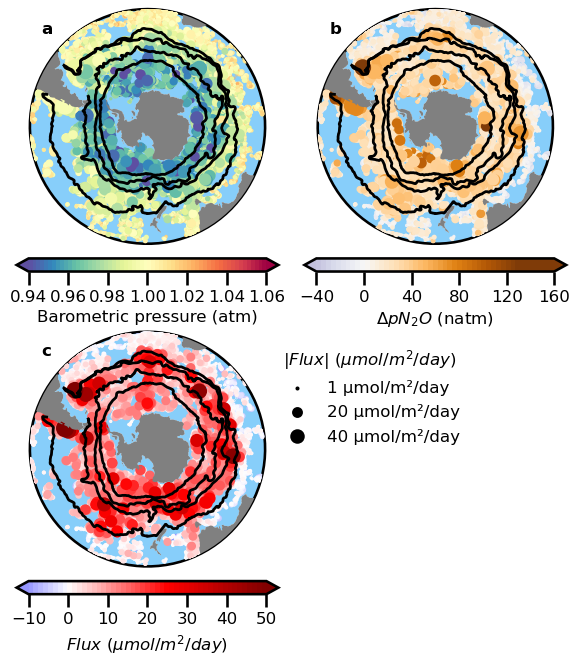

In [13]:
data = pd.read_csv('datasets/fig1.csv')

fig = plt.figure(figsize=(7.09, 8))
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1], height_ratios=[1, 1], wspace=0.1, hspace=0.1)

### SUBPLOT 1 ###
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.SouthPolarStereo())
ax1.text(0.05, 0.95, "a", fontweight="bold",
        horizontalalignment = "left",
        verticalalignment = "top",
        transform = ax1.transAxes,
        fontsize = 12)
setupmap(ax1)
param = "msl"
label = r'Barometric pressure (atm)'
surface = data.sort_values("Ft", ascending = True)
colormap = 'Spectral_r'
msllevs = np.arange(0.94,1.06,0.002)

cax1 = plt.scatter(x=surface["LONGITUDE"],y=surface["LATITUDE"],
                  c=surface[param],
                  s=np.abs(surface["Ft"])*2,
                  zorder=3,
                  vmin=0.94, vmax=1.06,
                  label = None,
                  transform=ccrs.PlateCarree(),
                 cmap = colormap)

# plot fronts
plotfronts(ax1)

bounds=msllevs
cbar1 = fig.colorbar(cax1, ax=ax1, orientation='horizontal', pad=0.05,
                    extend='both', boundaries=bounds,
                    ticks = msllevs[::10])
cbar1.set_label(label, fontsize = 12)
cbar1.ax.tick_params(labelsize = 12)

### SUBPLOT 2 ###
ax2 = fig.add_subplot(gs[0, 1], projection=ccrs.SouthPolarStereo())
ax2.text(0.05, 0.95, "b", fontweight="bold",
        horizontalalignment = "left",
        verticalalignment = "top",
        transform = ax2.transAxes,
        fontsize = 12)
setupmap(ax2)

param = "DpN2O_pred"
label = r'$\Delta pN_2O$ (natm)'
surface = data.sort_values("Ft", ascending = True)

cax2 = plt.scatter(x=surface["LONGITUDE"],y=surface["LATITUDE"],
                  c=surface[param],
                  s=np.abs(surface["Ft"])*2,
                  zorder=3,
                  vmin = -130, vmax = 130,
                  label = None,
                  transform=ccrs.PlateCarree(),
                 cmap = 'PuOr_r')

# plot fronts
plotfronts(ax2)

bounds=np.linspace(-40,160) #[i for i in np.arange(-40,200,40)]
cbar2 = fig.colorbar(cax2, ax=ax2, orientation='horizontal', pad=0.05,
                    extend='both', boundaries=bounds,
                    ticks = [i for i in np.arange(-40,200,40)])
cbar2.set_label(label, fontsize = 12)
cbar2.ax.tick_params(labelsize = 12)

### SUBPLOT 3 ###
ax3 = fig.add_subplot(gs[1, 0], projection=ccrs.SouthPolarStereo())
ax3.text(0.05, 0.95, "c", fontweight="bold",
        horizontalalignment = "left",
        verticalalignment = "top",
        transform = ax3.transAxes,
        fontsize = 12)
setupmap(ax3)
param = "Ft"
label = r'$Flux\ (\mu mol/m^2/day)$'
surface = data.sort_values("Ft", ascending = True)

cax3 = plt.scatter(x=surface["LONGITUDE"],y=surface["LATITUDE"],
                  c=surface[param],
                  s=np.abs(surface["Ft"])*2,
                  zorder=3,
                  vmax = 50, vmin = -50,
                  label = None,
                  transform=ccrs.PlateCarree(),
                 cmap = 'seismic')

# plot fronts
plotfronts(ax3)

bounds=np.linspace(-10,50) #[i for i in np.arange(-10,60,10)]
cbar3 = fig.colorbar(cax3, ax=ax3, orientation='horizontal', pad=0.05,
                    extend='both', boundaries=bounds,
                    ticks = [i for i in np.arange(-10,60,10)])
cbar3.set_label(label, fontsize = 12)
cbar3.ax.tick_params(labelsize = 12)

# dot size legend
flux_legend_values = [1, 20, 40]  # Example flux values (change to your specific range)
legend_labels = [f"{val} µmol/m²/day" for val in flux_legend_values]
legend_handles = [plt.scatter([], [], s=val*2, color='k', label=label)
                  for val, label in zip(flux_legend_values, legend_labels)]

ax3.legend(handles=legend_handles,title="$|Flux|\ (\mu mol/m^2/day)$",
           bbox_to_anchor=(1,1), loc='upper left', framealpha = 0.0,
          fontsize=12, title_fontsize=12)

plt.savefig("figures/figure1.pdf")#, bbox_inches = "tight")

plt.show()

# FIGURE 2

inputs: [['W14', 'ncep', 'observed'], ['W14', 'era5', 'observed'], ['L13', 'ncep', 'observed'], ['L13', 'era5', 'observed']]
0.3210364911226428
inputs: [['W14', 'ncep', '1atm'], ['W14', 'era5', '1atm'], ['L13', 'ncep', '1atm'], ['L13', 'era5', '1atm']]
0.8929258341551669
0.3338596365795798


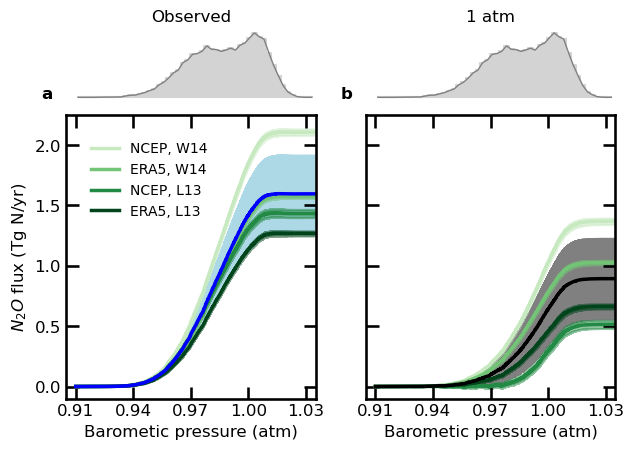

In [19]:
outputpath = 'datasets'

fig, axes = plt.subplots(1,2, figsize = (7.09, 4.73), sharey=True)

# Adjust BEFORE creating insets
plt.subplots_adjust(top=0.75, bottom=0.15)

ax = axes[0]
data_sorted = pd.read_csv("datasets/fig2a.csv")
mslarray= np.array(data_sorted["mslarray"])
mean_cumsum = np.array(data_sorted["mean_cumsum"])
total_uncertainty = np.array(data_sorted["total_uncertainty"])

inputs = generateinputs(["observed"], ["ncep", "era5"])
cumsums = np.empty((len(data_sorted),len(inputs)))
cmap = plt.get_cmap('Greens')
colors = cmap(np.linspace(0.25, 1, len(inputs)))

for count, test in enumerate(inputs):
    p = test[0]
    t = test[2]
    w = test[1]

    cumsum = np.cumsum(np.array(data_sorted[f"{t}{w}{p}"]))
    cumsums[:,count] = cumsum

    uncertainties = np.array(data_sorted[f"{t}{w}{p}_stdev"])
    uncertaintiessquared = uncertainties**2
    uncertaintiescumulative = np.cumsum(uncertaintiessquared)
    uncertainties = np.sqrt(uncertaintiescumulative)

    mslarray = np.array(data_sorted[f"msl_era5"])

    ax.fill_between(mslarray, (cumsum - uncertainties),
                (cumsum + uncertainties), zorder=1, color = colors[count],
                   alpha = 0.5)
    windlabel = f"{w}".upper()
    ax.plot(mslarray, cumsum, label = f"{windlabel}, {p}", color = colors[count])

wind_uncertainty = np.std(cumsums, axis = 1)

montecarlo_uncertainty = np.cumsum(np.array(data_sorted["combined_uncertainty"])**2)

bootstrap_uncertainty = 0.038*mean_cumsum#bootstrap_uncertainties[260]/np.mean(bootstrap_sums[260,:])*mean_cumsum

total_uncertainty = np.sqrt(
    wind_uncertainty**2 + 
    montecarlo_uncertainty + 
    bootstrap_uncertainty**2
)

ax.fill_between(mslarray, (mean_cumsum - total_uncertainty),
                (mean_cumsum + total_uncertainty), color = "lightblue", zorder=0)
ax.plot(mslarray, mean_cumsum, color = "b", label = None)
print(total_uncertainty[-1])

ax.legend(framealpha = 0, bbox_to_anchor=(0.05,0.95), loc = "upper left", fontsize = 10)
ax.set_ylabel(r"$N_2O$ flux (Tg N/yr)", fontsize = 12)
ax.set_xlabel("Barometic pressure (atm)", fontsize = 12)
ax.set_xlim([0.905, 1.035])
ax.set_ylim([-0.1, 2.25])
ax.set_xticks(np.linspace(0.91, 1.03, 5))
ax.set_yticks(np.linspace(0, 2.0, 5))
ax.tick_params(direction="in", top = True, right = True, labelsize=12)
ax.text(-0.1, 1.1, "a", fontweight="bold", fontsize = 12,
    horizontalalignment = "left",
    verticalalignment = "top",
    transform = ax.transAxes)

from matplotlib.transforms import Bbox

# Create an inset axis for the histogram (like a mountain range above the main plot)
inset_height = 0.25  # relative to figure height
inset_ax = fig.add_axes([ax.get_position().x0,        # same x start
                         ax.get_position().y1 + 0.03, # just above main axis
                         ax.get_position().width,     # same width
                         inset_height * ax.get_position().height])  # scale height

# Plot histogram
hist_counts, bin_edges = np.histogram(mslarray, bins=50)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Plot as a filled area for the "mountain range" look
inset_ax.fill_between(bin_centers, 0, hist_counts, color="lightgray", step="mid")
inset_ax.plot(bin_centers, hist_counts, color="gray", lw=1)

# Remove y-axis labels/ticks and match x-axis
inset_ax.set_xticks([])
inset_ax.set_yticks([])
inset_ax.set_xlim(ax.get_xlim())
inset_ax.spines["top"].set_visible(False)
inset_ax.spines["right"].set_visible(False)
inset_ax.spines["left"].set_visible(False)
inset_ax.spines["bottom"].set_visible(False)
inset_ax.set_title('Observed', fontsize = 12)

ax = axes[1]
data_sorted = pd.read_csv("datasets/fig2b.csv")
mslarray= np.array(data_sorted["mslarray"])
mean_cumsum = np.array(data_sorted["mean_cumsum"])
total_uncertainty = np.array(data_sorted["total_uncertainty"])
inputs = generateinputs(["1atm"], ["ncep", "era5"])

cmap = plt.get_cmap('Greens')
colors = cmap(np.linspace(0.25, 1, len(inputs)))

mean_cumsum = np.cumsum(np.array(data_sorted["combined_mean"]))

print(mean_cumsum[-1])

cumsums = np.empty((len(data_sorted),len(inputs)))

for count, test in enumerate(inputs):
    p = test[0]
    t = test[2]
    w = test[1]

    cumsum = np.cumsum(np.array(data_sorted[f"{t}{w}{p}"]))
    cumsums[:,count] = cumsum

    uncertainties = np.array(data_sorted[f"{t}{w}{p}_stdev"])
    uncertaintiessquared = uncertainties**2
    uncertaintiescumulative = np.cumsum(uncertaintiessquared)
    uncertainties = np.sqrt(uncertaintiescumulative)

    mslarray = np.array(data_sorted[f"msl_era5"])

    ax.fill_between(mslarray, (cumsum - uncertainties),
                (cumsum + uncertainties), zorder=1, color = colors[count],
                   alpha = 0.5)
    windlabel = f"{w}".upper()
    ax.plot(mslarray, cumsum, label = f"{windlabel}, {p}", color = colors[count])

wind_uncertainty = np.std(cumsums, axis = 1)

montecarlo_uncertainty = np.cumsum(np.array(data_sorted["combined_uncertainty"])**2)

bootstrap_uncertainty = 0.038*mean_cumsum#bootstrap_uncertainties[260]/np.mean(bootstrap_sums[260,:])*mean_cumsum

total_uncertainty = np.sqrt(
   wind_uncertainty**2 + 
    montecarlo_uncertainty + 
    bootstrap_uncertainty**2
)
ax.fill_between(mslarray, (mean_cumsum - total_uncertainty),
                (mean_cumsum + total_uncertainty), color = "gray", zorder=0)
ax.plot(mslarray, mean_cumsum, color = "k", label = "1 atm")
print(total_uncertainty[-1])

#ax.legend(framealpha = 0, bbox_to_anchor=(0.05,0.95), loc = "upper left", fontsize = 10)
ax.set_xlabel("Barometic pressure (atm)", fontsize = 12)
ax.set_xlim([0.905, 1.035])
ax.set_ylim([-0.1, 2.25])
ax.set_xticks(np.linspace(0.91, 1.03, 5))
ax.set_yticks(np.linspace(0, 2.0, 5))
ax.tick_params(direction="in", top = True, right = True, labelsize=12)
ax.text(-0.1, 1.1, "b", fontweight="bold", fontsize = 12,
    horizontalalignment = "left",
    verticalalignment = "top",
    transform = ax.transAxes)

from matplotlib.transforms import Bbox

# Create an inset axis for the histogram (like a mountain range above the main plot)
inset_height = 0.25  # relative to figure height
inset_ax = fig.add_axes([ax.get_position().x0,        # same x start
                         ax.get_position().y1 + 0.03, # just above main axis
                         ax.get_position().width,     # same width
                         inset_height * ax.get_position().height])  # scale height

# Plot histogram
hist_counts, bin_edges = np.histogram(mslarray, bins=50)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Plot as a filled area for the "mountain range" look
inset_ax.fill_between(bin_centers, 0, hist_counts, color="lightgray", step="mid")
inset_ax.plot(bin_centers, hist_counts, color="gray", lw=1)

# Remove y-axis labels/ticks and match x-axis
inset_ax.set_xticks([])
inset_ax.set_yticks([])
inset_ax.set_xlim(ax.get_xlim())
inset_ax.spines["top"].set_visible(False)
inset_ax.spines["right"].set_visible(False)
inset_ax.spines["left"].set_visible(False)
inset_ax.spines["bottom"].set_visible(False)
inset_ax.set_title('1 atm', fontsize = 12)

plt.savefig("figures/figure2.pdf")#, bbox_inches = "tight")

plt.show()

# FIGURE 3

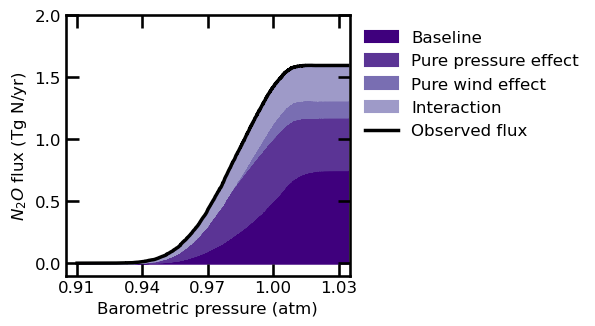

In [38]:
# Pure effects (no interaction)
data_sorted = pd.read_csv("datasets/fig3.csv")
conditions = ["observed", "medK", "1atm", "baseline"]
pure_wind_effect = data_sorted.Ft_cumulative1atm - data_sorted.Ft_cumulativebaseline
pure_pressure_effect = data_sorted.Ft_cumulativemedK - data_sorted.Ft_cumulativebaseline
interaction_continuous = data_sorted.Ft_cumulativeobserved - data_sorted.Ft_cumulativemedK - data_sorted.Ft_cumulative1atm + data_sorted.Ft_cumulativebaseline

# Stacked plot
cmap = plt.get_cmap('Purples')
colors = cmap(np.linspace(0.5, 1.0, len(conditions)))

fig, ax = plt.subplots(1,1, figsize = (7.09, 3.47))
plt.subplots_adjust(top=0.9, bottom=0.15, left=0.1, right=0.5)

ax.fill_between(mslarray, 
                0, data_sorted.Ft_cumulativebaseline,
color = colors[3],
                label="Baseline")
ax.fill_between(mslarray, 
                data_sorted.Ft_cumulativebaseline, 
                data_sorted.Ft_cumulativebaseline + pure_pressure_effect,
color = colors[2],
                label="Pure pressure effect")
ax.fill_between(mslarray, 
                data_sorted.Ft_cumulativebaseline + pure_pressure_effect, 
                data_sorted.Ft_cumulativebaseline + pure_pressure_effect + pure_wind_effect,
color = colors[1],
                label="Pure wind effect")
ax.fill_between(mslarray, 
                data_sorted.Ft_cumulativebaseline + pure_pressure_effect + pure_wind_effect, 
                data_sorted.Ft_cumulativebaseline + pure_pressure_effect + pure_wind_effect + interaction_continuous,
color = colors[0],
                label="Interaction")
ax.plot(mslarray,
        np.array(data_sorted.Ft_cumulativeobserved), 'k-', label="Observed flux")
ax.legend(framealpha = 0, bbox_to_anchor=(1.0,1.0), loc = "upper left", fontsize = 12)
ax.set_ylabel(r"$N_2O$ flux (Tg N/yr)", fontsize = 12)
ax.set_xlabel("Barometric pressure (atm)", fontsize = 12)
ax.set_xlim([0.905, 1.035])
ax.set_ylim([-0.1, 2.0])
ax.set_xticks(np.linspace(0.91, 1.03, 5))
#ax.set_yticks([0, 0.5, 1.0, 1.5, 2.0])
ax.tick_params(direction="in", top = True, right = True, labelsize=12)
#ax.set_title(windproduct)

plt.savefig("figures/figure3.pdf")#, bbox_inches = "tight")

plt.show()

# FIGURE 4

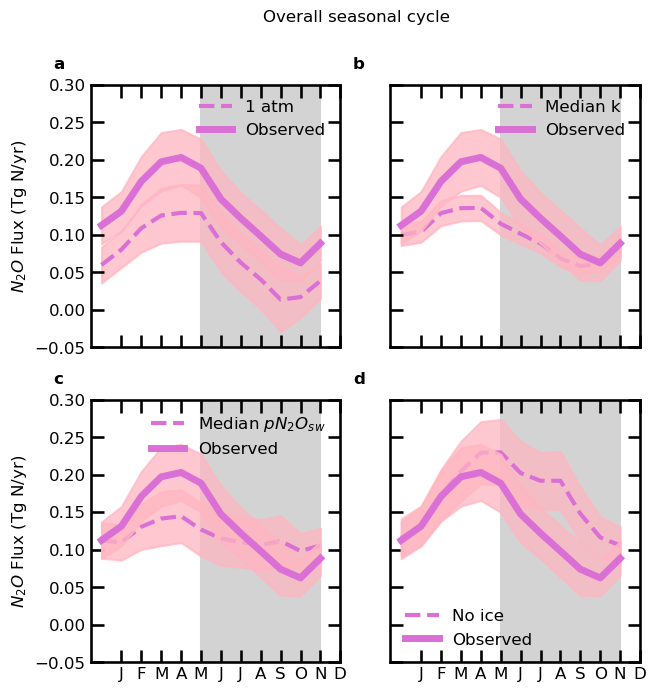

In [41]:
overall = pd.read_csv("datasets/fig4.csv")
cmap = plt.get_cmap('tab20c')
colors = cmap(np.linspace(0, 1, 10))
numeric_months = [1,2,3,4,5,6,7,8,9,10,11,12]

fillcolors = [colors[3],
              colors[1],
              colors[9]]

linecolors = [colors[2],
             colors[0],
             'k']

tests = ["1atm", "medK", "medN2O", "noice"]
labels = [
          "1 atm",
    "Median k",
          "Median $pN_2O_{sw}$",
         "No ice"]

linewidths = [3,3,3,1]
linestyles = ["-","--","--","-"]
subplotlabels = ["a", "b", "c", "d"]

fig, axes = plt.subplots(2,2, sharex = True, sharey=True, figsize = (7.09,7.5))

for i, test in enumerate(tests):
    ax = axes[i//2,i%2]
    ax.axvspan(5,11,color="lightgray", zorder=0)
    
    ax.fill_between(np.array(overall.index),
                    np.array(overall[f"mean_flux{test}"]-overall[f"total_uncertainty{test}"]),
                    np.array(overall[f"mean_flux{test}"]+overall[f"total_uncertainty{test}"]),
                    color = "lightpink",
                    alpha = 0.75, zorder=i, label = None)
    ax.plot(np.array(overall.index),
                    np.array(overall[f"mean_flux{test}"]), linewidth = 3,
            color = "orchid", zorder = i,
            linestyle = "--", label = labels[i])
    ax.fill_between(np.array(overall.index),
                    np.array(overall[f"mean_fluxobserved"]-overall[f"total_uncertaintyobserved"]),
                    np.array(overall[f"mean_fluxobserved"]+overall[f"total_uncertaintyobserved"]),
                    color = "lightpink",
                    alpha = 0.75, zorder=i, label = None)
    ax.plot(np.array(overall.index),
                    np.array(overall[f"mean_fluxobserved"]), linewidth = 5,
            color = "orchid", zorder = i,
            label = "Observed")
    ax.text(-0.15, 1.05, subplotlabels[i], fontweight="bold",
        horizontalalignment = "left",
        verticalalignment = "bottom",
        transform = ax.transAxes,
           fontsize = 12)

    ax.legend(fontsize = 12, framealpha = 0)
    #ax.set_title(labels[i], fontsize = 12)
    ax.set_ylim([-0.05, 0.3])
    ax.set_xticks(numeric_months)
    ax.set_xticklabels(["J", "F", "M", "A", "M", "J", "J", "A", "S", "O", "N", "D"],
                      fontsize = 12)
    if i%2 == 0:
        ax.set_ylabel("$N_2O$ Flux (Tg N/yr)", fontsize = 12)
    ax.tick_params(direction="in", top = True, right=True, labelsize = 12)

fig.suptitle("Overall seasonal cycle", fontsize = 12)

plt.savefig("figures/figure4.pdf")#, bbox_inches = "tight")

plt.show()

# FIGURE 5

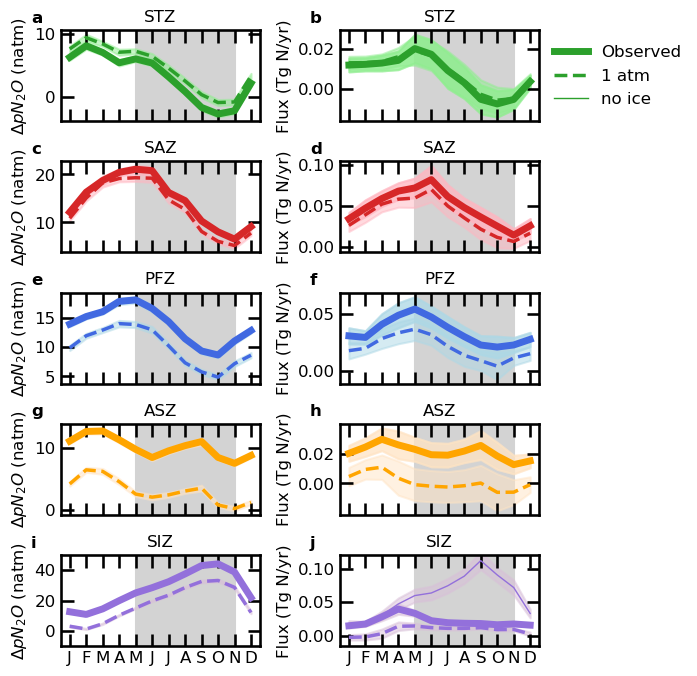

In [51]:
monthlyzonalmeans = pd.read_csv('datasets/fig5.csv', index_col = "zone")
grouped = pd.read_csv('datasets/fig5column2.csv', index_col = "zone")

numeric_months = [1,2,3,4,5,6,7,8,9,10,11,12]
zones = ["STZ", "SAZ","PFZ","ASZ","SIZ"]
zonecolors = ['C2', 'C3', 'royalblue', 'orange','mediumpurple']
fillcolors = ["lightgreen","lightpink","lightblue","bisque","thistle"]
zonelabels = ["STZ", "SAZ","PFZ","ASZ","SIZ"]
plotlabels = ["a","c","e","g","i",]
plotlabels2 = ["b","d", "f", "h", "j"]

fig, axes = plt.subplots(5,2, figsize = (7.09,8), sharex=True, sharey=False)
fig.subplots_adjust(wspace = 0.4, hspace = 0.44)
plt.subplots_adjust(left=0.1, right=0.775)
for i in range(5):
    ax = axes[i, 0]
    zone = zones[i]
    temp = monthlyzonalmeans.loc[zone]


    ax.axvspan(5,11,color="lightgray", zorder=0)
    ax.fill_between(numeric_months, temp.DpN2O_pred - temp.DpN2O_pred_sem, temp.DpN2O_pred + temp.DpN2O_pred_sem,
                    color = fillcolors[i], zorder=1,alpha=0.5)
    ax.plot(numeric_months, temp.DpN2O_pred,
           color = zonecolors[i], zorder=2, linewidth = 5, label = "real $\Delta pN_2O$")
    
    ax.fill_between(numeric_months, temp.DpN2O_pred2 - temp.DpN2O_pred2_sem, temp.DpN2O_pred2 + temp.DpN2O_pred2_sem,
                    color = fillcolors[i], zorder=1,alpha=0.5)
    ax.plot(numeric_months, temp.DpN2O_pred2,
           color = zonecolors[i], zorder=2, linestyle = "--",
           label = "1 atm")
    
    if i==4:
        ax.set_ylim([-10,50])
        ax.set_yticks([0,20,40])
    #else:
        #ax.set_ylim([-12, 25])
        #ax.set_yticks([-10,0,10,20])

    ax.text(-0.15, 1.05, plotlabels[i], fontweight="bold",
            horizontalalignment = "left",
            verticalalignment = "bottom",
            transform = ax.transAxes,
           fontsize = 12)
    ax.set_xticks(numeric_months)
    ax.set_xticklabels(["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"],
                      fontsize = 12)
    ax.set_ylabel("$\Delta pN_2O$ (natm)", fontsize = 12)
    ax.tick_params(direction = "in", top=True, right=True, labelsize = 12)
    ax.set_title(zone, fontsize = 12)

for i in range(5):
    ax = axes[i,1]
    zone = zones[i]
    temp = grouped.loc[zone]

    ax.axvspan(5,11,color="lightgray", zorder=0)
    
    ax.fill_between(numeric_months,
                    np.array(temp.mean_fluxobserved-temp.total_uncertaintyobserved),
                    np.array(temp.mean_fluxobserved+temp.total_uncertaintyobserved),
                    color = fillcolors[i], zorder=1,alpha=0.5)
    ax.plot(numeric_months, np.array(temp.mean_fluxobserved), color = zonecolors[i], zorder=2, linewidth = 5,
           label = "Observed")
    
    ax.fill_between(numeric_months,
                    np.array(temp.mean_flux1atm-temp.total_uncertainty1atm),
                    np.array(temp.mean_flux1atm+temp.total_uncertainty1atm),
                    color = fillcolors[i], zorder=1,alpha=0.5)
    ax.plot(numeric_months, np.array(temp.mean_flux1atm), color = zonecolors[i], zorder=2, linestyle = "--",
           label = "1 atm")
    '''
    ax.fill_between(numeric_months,
                    np.array(temp.mean_fluxmedK-temp.total_uncertaintymedK),
                    np.array(temp.mean_fluxmedK+temp.total_uncertaintymedK),
                    color = fillcolors[i], zorder=1,alpha=0.5)
    ax.plot(numeric_months, np.array(temp.mean_fluxmedK), color = zonecolors[i], zorder=2, linestyle = "--",
           label = "Med. k")  
    '''
    ax.fill_between(numeric_months,
                np.array(temp.mean_fluxnoice-temp.total_uncertaintynoice),
                np.array(temp.mean_fluxnoice+temp.total_uncertaintynoice),
                color = fillcolors[i], zorder=1,alpha=0.5)
    ax.plot(numeric_months, np.array(temp.mean_fluxnoice), color = zonecolors[i], zorder=3, linewidth = 1,
           label = "no ice")

    ax.set_xticks(numeric_months)
    ax.set_xticklabels(["J", "F", "M", "A", "M", "J", "J", "A", "S", "O", "N", "D"],#["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"],
                      )
    if i==0:
        ax.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize = 12, framealpha = 0)#,title="Sensitivity test", 
        ax.set_yticks([0.0,0.02])
    elif i==1:
        ax.set_yticks([0, 0.05, 0.1])
    elif i==2:
        ax.set_yticks([0, 0.05])
    elif i==3:
        ax.set_yticks([0.0,0.02])
    elif i==4: 
        ax.set_ylim([-0.015, 0.12])
        ax.set_yticks([0,0.05,0.1])
    #else:
        #ax.set_ylim([-0.015, 0.08])
        #ax.set_yticks([0,0.03,0.06])
    
    ax.tick_params(direction = "in", top=True, right=True, labelsize = 12)
    ax.text(-0.15, 1.05, plotlabels2[i], fontweight="bold",
        horizontalalignment = "left",
        verticalalignment = "bottom",
        transform = ax.transAxes,
           fontsize = 12)    
    ax.set_ylabel("Flux (Tg N/yr)", fontsize = 12)
    ax.set_title(zone, fontsize = 12)

plt.savefig("figures/figure5.pdf")#, bbox_inches = "tight")

plt.show()